# 0. 라이브러리 및 데이터 불러오기


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_digits

import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense

import random

In [2]:
print("library version check")
print("numpy: ", np.__version__)
print("pandas: ", pd.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", mpl.__version__)
print("sklearn: ", sklearn.__version__)
print("tensorflow: ", tensorflow.__version__)

library version check
numpy:  1.23.5
pandas:  1.5.1
seaborn:  0.12.1
matplotlib:  3.6.2
sklearn:  1.1.3
tensorflow:  2.10.0


In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

# 1. breast_cancer: 이진분류

In [4]:
cancer = load_breast_cancer()

## 1.1 데이터 전처리

In [5]:
#딥러닝 모델 만들 때는 데이터프레임으로는 fit할 수 없음
x_data = cancer["data"]
y_data = cancer["target"]

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify = y_data)

In [7]:
minmax = MinMaxScaler()
x_train_scaled = minmax.fit_transform(x_train)
x_test_scaled = minmax.transform(x_test)

In [8]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (455, 30)
y_train:  (455,)
x_test:  (114, 30)
y_test:  (114,)


## 1.2 RFC

RandomForestClassifier
* n_estimators= 300
* oob_score=True
* max_depth = None
* max_features = "sqrt"
* min_samples_leaf = 5
* min_samples_split = 4
* random_state=209

The accuracy of the RFC is 0.9561

## 1.3 단층 신경망

* breast cancer 데이터는 악성과 양성 종양을 맞추는 이진분류 
* 이진 분류의 경우 출력층의 노드수와 활성함수는?

**초기 가중치 문제**
* 가중치 초기화 방법을 따로 설정해 주지 않으면 일정 구간 내에서 랜덤하게 찍는 random_uniform으로 정해짐
* 이 방식은 오차 역전파(back propagation) 과정에서 미분한 gradient가 지나치게 커지거나(exploding gradient) 소실되는(vanishing gradient) 문제가 발생할 수 있음
* 따라서, 어떻게 가중치를 초기화할 것인가에 대한 지속적인 연구가 진행되고 있음

* lecun_uniform, lecun_normal: 98년도에 얀 르쿤(CNN 제안)이 제기한 방법
* glorot_uniform, glorot_normal
* he_uniform, he_normal: ResNet으로도 유명한 마이크로소프트(현재는 Facebook)의 Kaiming He가 2015년에 제안

In [9]:
random.seed(42)
# 입력노드 수 = feature 수
input_node = 30
# 출력노드 수
output_node = 1

#모델
model_cancer = Sequential()
model_cancer.add(Dense(output_node, 
                       # kernel_initializer='zeros',       # 'he_normal'
                       activation = "sigmoid",
                       input_shape = (input_node,)
                      ))

In [10]:
model_cancer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


In [11]:
initial_weight = model_cancer.get_weights()
initial_weight

[array([[ 0.3151644 ],
        [ 0.143094  ],
        [-0.12431794],
        [ 0.39593804],
        [-0.37125674],
        [ 0.13403457],
        [ 0.41398472],
        [-0.29219836],
        [ 0.02093178],
        [ 0.11505312],
        [-0.3639034 ],
        [-0.04719913],
        [ 0.41005498],
        [-0.02609637],
        [ 0.00259247],
        [ 0.23375493],
        [-0.42337322],
        [-0.27066872],
        [ 0.01253092],
        [-0.3814954 ],
        [-0.40681818],
        [ 0.30616975],
        [ 0.36552787],
        [-0.20893623],
        [ 0.31634587],
        [-0.3277787 ],
        [-0.03318444],
        [ 0.05518788],
        [ 0.05868104],
        [-0.2638222 ]], dtype=float32),
 array([0.], dtype=float32)]

In [12]:
initial_weight[0].shape

(30, 1)

In [13]:
# 이진 분류에서 loss function은? 

model_cancer.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics = ['accuracy'])

### 학습

* validation data: 검증 데이터. 학습 중 모델 평가를 위해 분리해 놓는 데이터
* batch size: 학습에 들어가는 샘플 수 
* epochs: 모든 학습 데이터를 학습하는 횟수


* 예를들어, 1000개의 샘플을 학습 데이터로 가지고 있다고 하자.
    * validation split을 0.2로 주면 20%의 데이터인 200개를 모델이 잘 학습하고 있는지 평가하는 데이터로 사용. 따라서, 남은 800개 데이터로 학습 진행
    * bach size가 100이면 100개의 샘플이 들어가서 학습하고 가중치가 갱신되므로 800개의 학습 데이터를 한 번 학습하는 동안 가중치는 8번 갱신. 이것이 epoch = 1
    * epochs = 5이면 1000개의 학습 데이터가 5번 학습된다는 의미. 
    * 따라서 총 가중치 갱신은 8$\times$5 = 40  

In [14]:
x_train.shape

(455, 30)

In [15]:
455*0.8

364.0

In [16]:
model_cancer_hist = model_cancer.fit(x_train_scaled, 
                                     y_train,
                                     epochs=10, 
                                     batch_size=10, 
                                     validation_split=0.2,
                                     # verbose = 1
                                    )

Epoch 1/10
37/37 [==============================] - 1s 14ms/step - loss: 0.6919 - accuracy: 0.5907 - val_loss: 0.6892 - val_accuracy: 0.5495
Epoch 2/10
37/37 [==============================] - 0s 4ms/step - loss: 0.6775 - accuracy: 0.6346 - val_loss: 0.6746 - val_accuracy: 0.5934
Epoch 3/10
37/37 [==============================] - 0s 3ms/step - loss: 0.6643 - accuracy: 0.6923 - val_loss: 0.6603 - val_accuracy: 0.6813
Epoch 4/10
37/37 [==============================] - 0s 3ms/step - loss: 0.6520 - accuracy: 0.7802 - val_loss: 0.6472 - val_accuracy: 0.7802
Epoch 5/10
37/37 [==============================] - 0s 4ms/step - loss: 0.6399 - accuracy: 0.7747 - val_loss: 0.6357 - val_accuracy: 0.8132
Epoch 6/10
37/37 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.8242 - val_loss: 0.6232 - val_accuracy: 0.8022
Epoch 7/10
37/37 [==============================] - 0s 4ms/step - loss: 0.6173 - accuracy: 0.8379 - val_loss: 0.6126 - val_accuracy: 0.8352
Epoch 8/10
37/37 [=

In [17]:
# 학습이 종료된 후 가중치 
model_cancer.get_weights()

[array([[ 0.2221076 ],
        [ 0.17643502],
        [-0.23034571],
        [ 0.22391333],
        [-0.26825154],
        [ 0.01412139],
        [ 0.17925666],
        [-0.53172874],
        [ 0.13136375],
        [ 0.3221901 ],
        [-0.5499824 ],
        [ 0.1414348 ],
        [ 0.2232331 ],
        [-0.25948402],
        [ 0.21893977],
        [ 0.24208526],
        [-0.42616963],
        [-0.24575648],
        [ 0.19247904],
        [-0.2415572 ],
        [-0.56101334],
        [ 0.32497886],
        [ 0.20120117],
        [-0.42416918],
        [ 0.41233018],
        [-0.47624496],
        [-0.23375681],
        [-0.12255041],
        [ 0.10021961],
        [-0.21298514]], dtype=float32),
 array([0.22607377], dtype=float32)]

### 학습과정 시각화

In [18]:
model_cancer_hist.history

{'loss': [0.6918935775756836,
  0.6775472164154053,
  0.6643074154853821,
  0.6520078182220459,
  0.6399050951004028,
  0.6282222270965576,
  0.6172781586647034,
  0.6073235273361206,
  0.5967891216278076,
  0.5871664881706238],
 'accuracy': [0.5906593203544617,
  0.6346153616905212,
  0.692307710647583,
  0.7802197933197021,
  0.7747252583503723,
  0.8241758346557617,
  0.8379120826721191,
  0.8269230723381042,
  0.8543956279754639,
  0.8598901033401489],
 'val_loss': [0.6891738772392273,
  0.6746337413787842,
  0.6603226065635681,
  0.6471824049949646,
  0.6357425451278687,
  0.6231945753097534,
  0.6125611066818237,
  0.6028236150741577,
  0.5916316509246826,
  0.5824947953224182],
 'val_accuracy': [0.5494505763053894,
  0.593406617641449,
  0.6813187003135681,
  0.7802197933197021,
  0.8131868243217468,
  0.8021978139877319,
  0.8351648449897766,
  0.8241758346557617,
  0.8461538553237915,
  0.8681318759918213]}

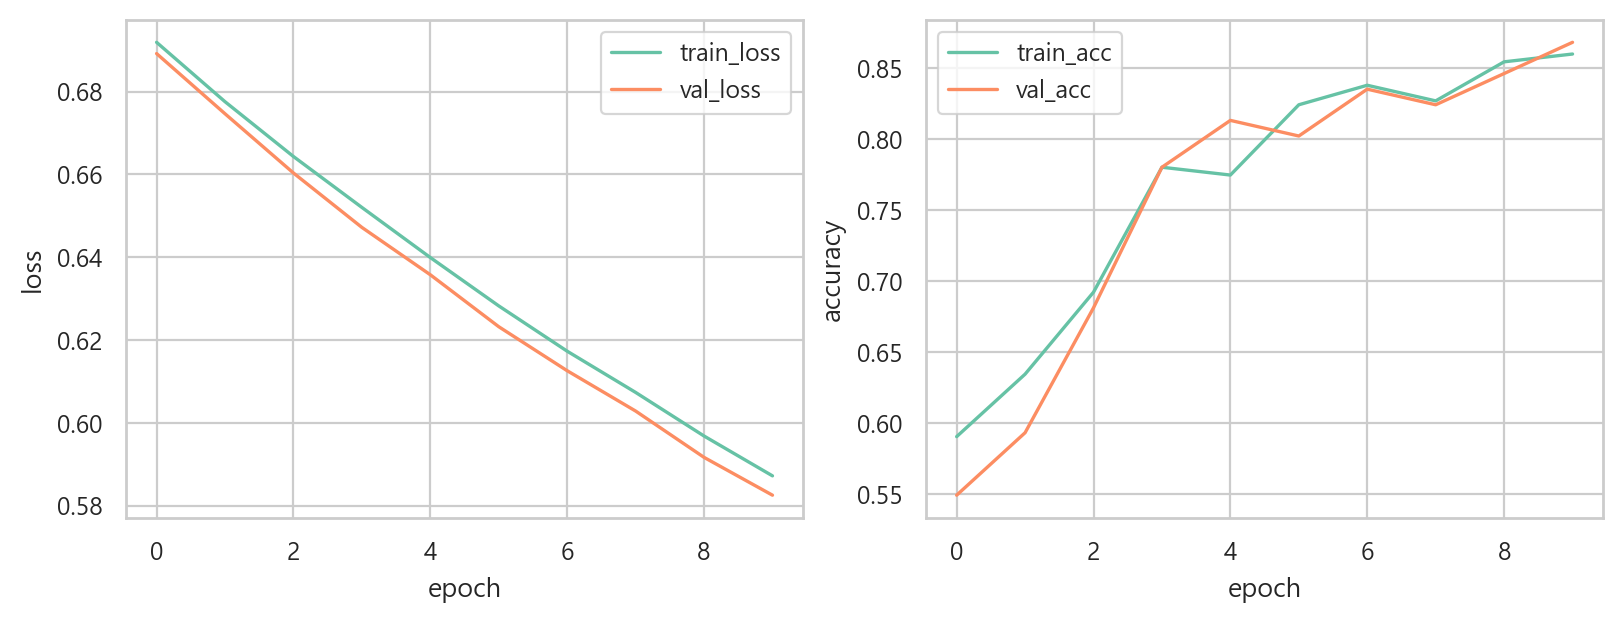

In [19]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize = (8,3))

ax_loss.plot(model_cancer_hist.history["loss"], label="train_loss")
ax_loss.plot(model_cancer_hist.history["val_loss"], label="val_loss")
ax_loss.set(xlabel = "epoch", ylabel = "loss")
ax_loss.legend()

ax_acc.plot(model_cancer_hist.history["accuracy"], label="train_acc")
ax_acc.plot(model_cancer_hist.history["val_accuracy"], label="val_acc")
ax_acc.set(xlabel = "epoch", ylabel = "accuracy")
ax_acc.legend();

### 모델 평가

In [20]:
model_cancer.predict(x_test_scaled)

4/4 [==============================] - 0s 2ms/step


array([[0.40635827],
       [0.59076595],
       [0.55353796],
       [0.5275033 ],
       [0.35008216],
       [0.55124485],
       [0.5828784 ],
       [0.45173416],
       [0.4513891 ],
       [0.37220213],
       [0.55766785],
       [0.5091134 ],
       [0.5381723 ],
       [0.4489074 ],
       [0.52163184],
       [0.545432  ],
       [0.54952854],
       [0.60360426],
       [0.54564756],
       [0.53803706],
       [0.49215153],
       [0.5428824 ],
       [0.64368284],
       [0.5729277 ],
       [0.63596904],
       [0.5008907 ],
       [0.39950007],
       [0.6142824 ],
       [0.5774002 ],
       [0.591734  ],
       [0.4365087 ],
       [0.55153745],
       [0.62196   ],
       [0.49023697],
       [0.4581047 ],
       [0.5889146 ],
       [0.62219244],
       [0.53469855],
       [0.5449066 ],
       [0.4422182 ],
       [0.588241  ],
       [0.55500114],
       [0.5772192 ],
       [0.3841716 ],
       [0.5268702 ],
       [0.4934642 ],
       [0.6400969 ],
       [0.616

In [21]:
model_cancer.predict(x_test_scaled).shape

4/4 [==============================] - 0s 2ms/step


(114, 1)

In [22]:
model_cancer.predict(x_test_scaled).flatten()

4/4 [==============================] - 0s 2ms/step


array([0.40635827, 0.59076595, 0.55353796, 0.5275033 , 0.35008216,
       0.55124485, 0.5828784 , 0.45173416, 0.4513891 , 0.37220213,
       0.55766785, 0.5091134 , 0.5381723 , 0.4489074 , 0.52163184,
       0.545432  , 0.54952854, 0.60360426, 0.54564756, 0.53803706,
       0.49215153, 0.5428824 , 0.64368284, 0.5729277 , 0.63596904,
       0.5008907 , 0.39950007, 0.6142824 , 0.5774002 , 0.591734  ,
       0.4365087 , 0.55153745, 0.62196   , 0.49023697, 0.4581047 ,
       0.5889146 , 0.62219244, 0.53469855, 0.5449066 , 0.4422182 ,
       0.588241  , 0.55500114, 0.5772192 , 0.3841716 , 0.5268702 ,
       0.4934642 , 0.6400969 , 0.6161321 , 0.50311816, 0.45007956,
       0.50768924, 0.56292844, 0.5873896 , 0.48768866, 0.5864093 ,
       0.58144915, 0.57780266, 0.4717443 , 0.39495817, 0.5826123 ,
       0.57232195, 0.629219  , 0.5517613 , 0.5807962 , 0.36377394,
       0.54616886, 0.52299345, 0.5463115 , 0.52350986, 0.5141065 ,
       0.63157046, 0.59097534, 0.60665834, 0.39292017, 0.49094

In [23]:
pred_cancer = model_cancer.predict(x_test_scaled).flatten() >= 0.5
pred_cancer

4/4 [==============================] - 0s 3ms/step


array([False,  True,  True,  True, False,  True,  True, False, False,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True, False,  True,  True, False, False,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
       False,  True,  True,  True, False,  True,  True,  True, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False,  True,  True,  True,  True,
        True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False, False, False,  True, False,  True,  True,
        True, False, False, False,  True, False, False,  True, False,
        True, False, False, False,  True,  True])

In [24]:
y_test

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1])

In [25]:
metrics.accuracy_score(pred_cancer, y_test)

0.8947368421052632

# 2. Digits: 다중분류

In [26]:
digits = load_digits()
digits

{'data': array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., 10.,  0.,  0.],
        [ 0.,  0.,  0., ..., 16.,  9.,  0.],
        ...,
        [ 0.,  0.,  1., ...,  6.,  0.,  0.],
        [ 0.,  0.,  2., ..., 12.,  0.,  0.],
        [ 0.,  0., 10., ..., 12.,  1.,  0.]]),
 'target': array([0, 1, 2, ..., 8, 9, 8]),
 'frame': None,
 'feature_names': ['pixel_0_0',
  'pixel_0_1',
  'pixel_0_2',
  'pixel_0_3',
  'pixel_0_4',
  'pixel_0_5',
  'pixel_0_6',
  'pixel_0_7',
  'pixel_1_0',
  'pixel_1_1',
  'pixel_1_2',
  'pixel_1_3',
  'pixel_1_4',
  'pixel_1_5',
  'pixel_1_6',
  'pixel_1_7',
  'pixel_2_0',
  'pixel_2_1',
  'pixel_2_2',
  'pixel_2_3',
  'pixel_2_4',
  'pixel_2_5',
  'pixel_2_6',
  'pixel_2_7',
  'pixel_3_0',
  'pixel_3_1',
  'pixel_3_2',
  'pixel_3_3',
  'pixel_3_4',
  'pixel_3_5',
  'pixel_3_6',
  'pixel_3_7',
  'pixel_4_0',
  'pixel_4_1',
  'pixel_4_2',
  'pixel_4_3',
  'pixel_4_4',
  'pixel_4_5',
  'pixel_4_6',
  'pixel_4_7',
  'pixel_5_0',
  'pixel_5_1',
 

In [27]:
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [28]:
digits["images"].shape

(1797, 8, 8)

index:  209 image의 숫자:  0


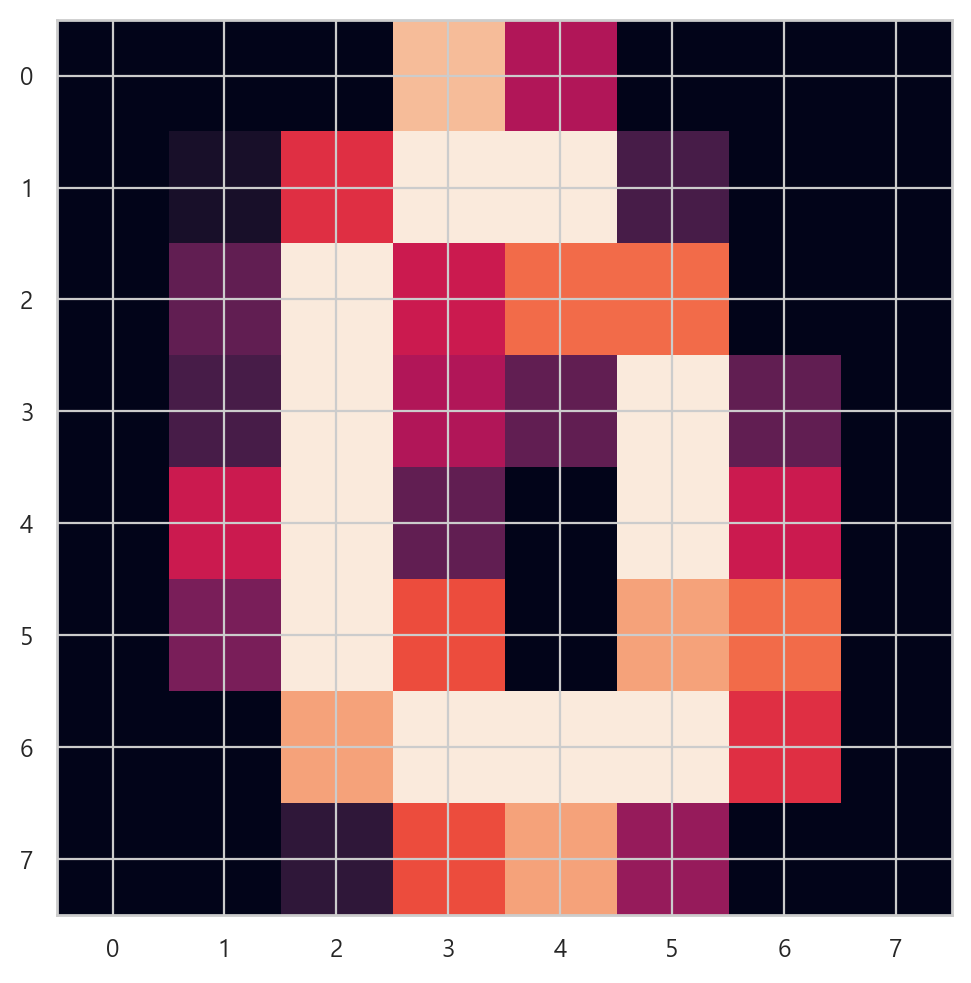

In [29]:
i = 209
plt.imshow(digits["images"][i])
print("index: ", i, "image의 숫자: ", digits["target"][i]);

In [30]:
x_data = digits["images"]
y_data = digits["target"]

In [31]:
np.unique(y_data, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64))

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify = y_data)

In [33]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (1437, 8, 8)
y_train:  (1437,)
x_test:  (360, 8, 8)
y_test:  (360,)


In [34]:
print(x_train.min(), x_train.max())

0.0 16.0


In [35]:
x_train, x_test = x_train / x_train.max(), x_test / x_train.max()

In [36]:
# 데이터의 shape을 변경해 주자.
x_train_re = np.reshape(x_train, (x_train.shape[0], 64))
x_test_re = np.reshape(x_test, (x_test.shape[0], 64))

In [37]:
x_train_re.shape

(1437, 64)

In [38]:
y_train

array([5, 0, 5, ..., 9, 7, 9])

In [39]:
# one-hot encoding으로 변경하자. 
y_train = to_categorical(y_train)
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## 2.1 RFC

In [40]:
print("x_train: ", x_train_re.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test_re.shape)
print("y_test: ", y_test.shape)

x_train:  (1437, 64)
y_train:  (1437, 10)
x_test:  (360, 64)
y_test:  (360,)


In [41]:
rfc = RandomForestClassifier(oob_score=True, random_state=209) 
rfc.fit(x_train_re, y_train)

RandomForestClassifier(oob_score=True, random_state=209)

In [42]:
rfc.predict(x_test_re)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [43]:
rfc.predict(x_test_re)[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [44]:
np.argmax(rfc.predict(x_test_re)[0])

5

In [45]:
pred = [np.argmax(i) for i in rfc.predict(x_test_re)]
metrics.accuracy_score(pred, y_test)

0.8777777777777778

## 2.2 단층 신경망

* digits 데이터는 0부터 9까지 클래스 10개인 다중 분류
* 다중 분류의 경우 출력층의 노드수와 활성함수는?

In [46]:
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_train:  (1437, 8, 8)
y_train:  (1437, 10)
x_test:  (360, 8, 8)
y_test:  (360,)


In [47]:
print("x_train: ", x_train_re.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test_re.shape)
print("y_test: ", y_test.shape)

x_train:  (1437, 64)
y_train:  (1437, 10)
x_test:  (360, 64)
y_test:  (360,)


In [48]:
random.seed(209)
# 입력노드 수 = feature 수
input_node = 8*8
# 출력노드 수
output_node = 10

#모델
model_digit = Sequential()
model_digit.add(Dense(output_node, 
                      activation = "softmax",
                      input_shape = (input_node,)
                     ))

In [49]:
model_digit.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________


In [50]:
model_digit.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics = ['accuracy'])

In [51]:
x_train.shape

(1437, 8, 8)

In [52]:
y_train.shape

(1437, 10)

In [53]:
# fit을 위한 하이퍼 파라미터를 정하시오.
model_digit_hist = model_digit.fit(x_train_re, 
                                   y_train,
                                   epochs=100, 
                                   batch_size=10, 
                                   validation_split=0.2)

Epoch 1/100
115/115 [==============================] - 1s 5ms/step - loss: 2.1868 - accuracy: 0.2820 - val_loss: 1.9877 - val_accuracy: 0.3993
Epoch 2/100
115/115 [==============================] - 0s 3ms/step - loss: 1.7666 - accuracy: 0.5657 - val_loss: 1.6751 - val_accuracy: 0.6458
Epoch 3/100
115/115 [==============================] - 0s 3ms/step - loss: 1.4776 - accuracy: 0.7572 - val_loss: 1.4301 - val_accuracy: 0.7569
Epoch 4/100
115/115 [==============================] - 0s 3ms/step - loss: 1.2548 - accuracy: 0.8433 - val_loss: 1.2339 - val_accuracy: 0.8056
Epoch 5/100
115/115 [==============================] - 0s 4ms/step - loss: 1.0804 - accuracy: 0.8886 - val_loss: 1.0862 - val_accuracy: 0.8438
Epoch 6/100
115/115 [==============================] - 0s 3ms/step - loss: 0.9453 - accuracy: 0.8964 - val_loss: 0.9693 - val_accuracy: 0.8542
Epoch 7/100
115/115 [==============================] - 0s 3ms/step - loss: 0.8382 - accuracy: 0.9086 - val_loss: 0.8762 - val_accuracy: 0.8542

Epoch 58/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1364 - accuracy: 0.9791 - val_loss: 0.2075 - val_accuracy: 0.9479
Epoch 59/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1340 - accuracy: 0.9800 - val_loss: 0.2052 - val_accuracy: 0.9514
Epoch 60/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1318 - accuracy: 0.9809 - val_loss: 0.2036 - val_accuracy: 0.9479
Epoch 61/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1300 - accuracy: 0.9809 - val_loss: 0.2021 - val_accuracy: 0.9514
Epoch 62/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1280 - accuracy: 0.9809 - val_loss: 0.1988 - val_accuracy: 0.9549
Epoch 63/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1263 - accuracy: 0.9817 - val_loss: 0.1984 - val_accuracy: 0.9514
Epoch 64/100
115/115 [==============================] - 0s 3ms/step - loss: 0.1244 - accuracy: 0.9817 - val_loss: 0.1974 - val_accuracy:

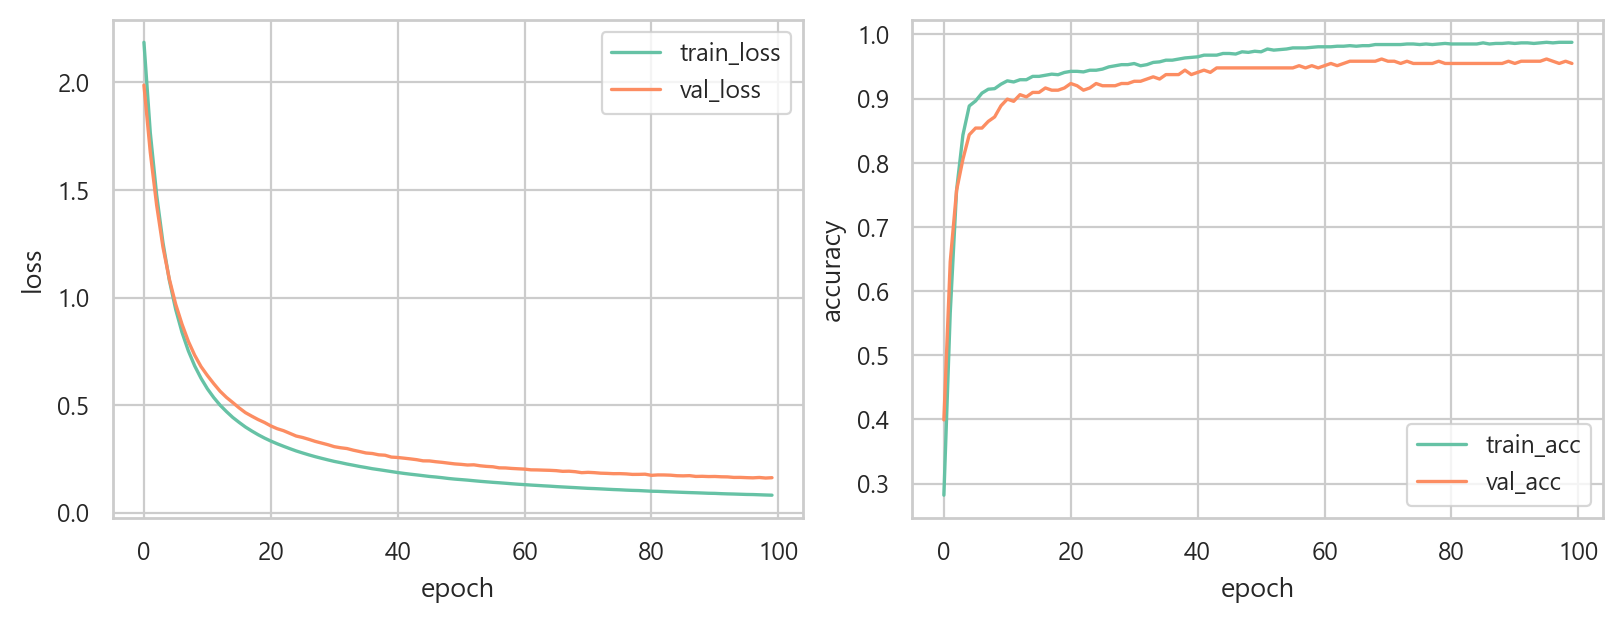

In [54]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize = (8,3))

ax_loss.plot(model_digit_hist.history["loss"], label="train_loss")
ax_loss.plot(model_digit_hist.history["val_loss"], label="val_loss")
ax_loss.set(xlabel = "epoch",
       ylabel = "loss")
ax_loss.legend()

ax_acc.plot(model_digit_hist.history["accuracy"], label="train_acc")
ax_acc.plot(model_digit_hist.history["val_accuracy"], label="val_acc")
ax_acc.set(xlabel = "epoch",
       ylabel = "accuracy")
ax_acc.legend();

In [55]:
model_digit.predict(x_test_re)

12/12 [==============================] - 0s 1ms/step


array([[1.1479025e-04, 1.2692503e-05, 8.1900782e-07, ..., 3.3107656e-06,
        7.8262569e-04, 8.3523735e-02],
       [6.0216428e-07, 1.5576396e-04, 9.7795469e-01, ..., 8.4549754e-08,
        3.8046904e-03, 1.0979282e-04],
       [7.4816438e-05, 3.5798171e-01, 2.5808213e-03, ..., 7.0050140e-03,
        5.3349155e-01, 1.5351798e-02],
       ...,
       [9.9958974e-01, 3.2384850e-08, 1.1133911e-07, ..., 1.4902843e-05,
        1.4581712e-05, 6.0258684e-05],
       [1.8728976e-07, 1.4596122e-03, 2.6408818e-03, ..., 2.7933347e-06,
        4.9966881e-03, 1.7182613e-03],
       [3.5446759e-05, 4.6221045e-04, 7.1169319e-09, ..., 5.4823846e-05,
        1.2871901e-05, 5.1948383e-08]], dtype=float32)

In [56]:
model_digit.predict(x_test_re)[0]

12/12 [==============================] - 0s 2ms/step


array([1.1479025e-04, 1.2692503e-05, 8.1900782e-07, 9.0610542e-05,
       7.3170195e-05, 9.1524535e-01, 1.5294969e-04, 3.3107656e-06,
       7.8262569e-04, 8.3523735e-02], dtype=float32)

In [57]:
np.argmax(model_digit.predict(x_test_re)[0])

12/12 [==============================] - 0s 2ms/step


5

In [58]:
pred_digit = [np.argmax(i) for i in model_digit.predict(x_test_re)]

12/12 [==============================] - 0s 2ms/step


In [59]:
metrics.accuracy_score(pred_digit, y_test)

0.9694444444444444

# 저장

In [60]:
# model_digit.save("../model/digit_classifier.h5")

# 불러오기

In [61]:
# model = load_model("../model/digit_classifier.h5")

In [62]:
# model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 650
Trainable params: 650
Non-trainable params: 0
_________________________________________________________________
